<a href="https://colab.research.google.com/github/SinchanaShylajaArun/AI-Localisation-and-Pathfinding-System/blob/main/AI_project2_Sinchana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ship generated: 20x20 grid
Open cells: 285
Blocked cells: 115
LocatorBot position: (15, 11)
Space Roomba position: (10, 5)


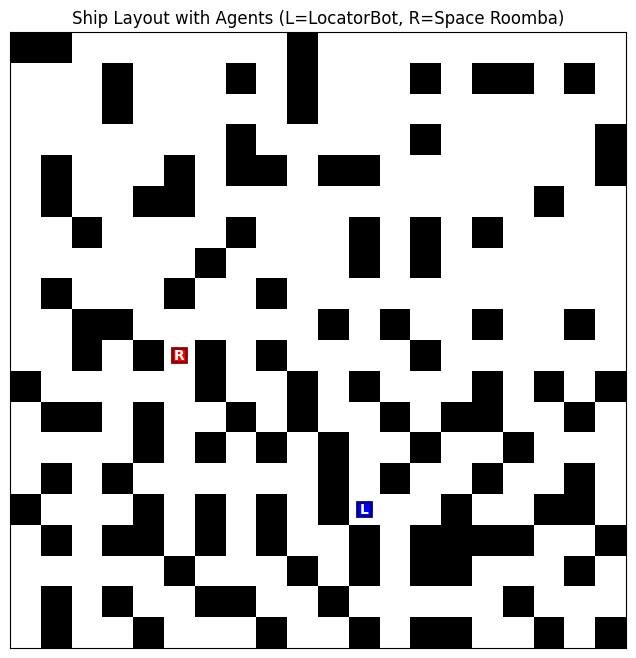

In [32]:
# --- Cell 1: Ship Generation + Agent Placement ---
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

D = 20  # Grid size
open, blocked = 0, 1  # Your original convention

# Generate the ship layout
ship = [[blocked for _ in range(D)] for _ in range(D)]
si, sj = random.randint(0, D-1), random.randint(0, D-1)
ship[si][sj] = open

def exactly_one_open_neighbor(i, j, deadend=False):
    count = 0
    if i>0 and ship[i-1][j]==open: count+=1
    if i<D-1 and ship[i+1][j]==open: count+=1
    if j>0 and ship[i][j-1]==open: count+=1
    if j<D-1 and ship[i][j+1]==open: count+=1
    if deadend: return count==1
    return ship[i][j]==blocked and count==1

while True:
    candidates = [(i,j) for i in range(D) for j in range(D) if exactly_one_open_neighbor(i,j)]
    if not candidates: break
    i,j = random.choice(candidates)
    ship[i][j]=open

def find_deadends():
    return [(i, j) for i in range(D) for j in range(D)
            if ship[i][j]==open and exactly_one_open_neighbor(i, j, True)]

deadends = find_deadends()
count = 0
for i, j in deadends:
    neighbors = []
    if i>0 and ship[i-1][j]==blocked: neighbors.append((i-1, j))
    if i<D-1 and ship[i+1][j]==blocked: neighbors.append((i+1, j))
    if j>0 and ship[i][j-1]==blocked: neighbors.append((i, j-1))
    if j<D-1 and ship[i][j+1]==blocked: neighbors.append((i, j+1))
    if neighbors and count<len(deadends)//2:
        ni, nj = random.choice(neighbors)
        ship[ni][nj]=open
        count += 1

# Convert to numpy array for easier handling
ship_grid = np.array(ship)

# Get open cells
open_cells = [(i,j) for i in range(D) for j in range(D) if ship_grid[i,j] == open]

# Randomly place LocatorBot and Space Roomba
locator_pos = random.choice(open_cells)
available_cells = [cell for cell in open_cells if cell != locator_pos]
roomba_pos = random.choice(available_cells)

print(f"Ship generated: {D}x{D} grid")
print(f"Open cells: {len(open_cells)}")
print(f"Blocked cells: {D*D - len(open_cells)}")
print(f"LocatorBot position: {locator_pos}")
print(f"Space Roomba position: {roomba_pos}")

# Visualization with agents
cmap = colors.ListedColormap(['white', 'black'])  # 0=white (open), 1=black (blocked)
plt.figure(figsize=(8,8))
plt.imshow(ship_grid, cmap=cmap, vmin=0, vmax=1)

# Plot agents
li, lj = locator_pos
ri, rj = roomba_pos

# Plot LocatorBot (Blue)
plt.plot(lj, li, 's', markersize=10, color='blue', markeredgecolor='darkblue', markeredgewidth=2)
plt.text(lj, li, 'L', ha='center', va='center', fontweight='bold', color='white')

# Plot Space Roomba (Red)
plt.plot(rj, ri, 's', markersize=10, color='red', markeredgecolor='darkred', markeredgewidth=2)
plt.text(rj, ri, 'R', ha='center', va='center', fontweight='bold', color='white')

plt.title('Ship Layout with Agents (L=LocatorBot, R=Space Roomba)')
plt.xticks([])
plt.yticks([])
plt.show()

In [33]:
# --- Cell 2: Baseline 1 - Project 1's Optimal Strategy ---
import time
from queue import PriorityQueue

def simulate_single_move(position, move, ship_grid):
    """Simulate a single move from a position"""
    x, y = position
    grid_size = len(ship_grid)

    if move == "UP" and x > 0 and ship_grid[x-1][y] == open:
        return (x-1, y)
    elif move == "DOWN" and x < grid_size-1 and ship_grid[x+1][y] == open:
        return (x+1, y)
    elif move == "LEFT" and y > 0 and ship_grid[x][y-1] == open:
        return (x, y-1)
    elif move == "RIGHT" and y < grid_size-1 and ship_grid[x][y+1] == open:
        return (x, y+1)
    else:
        return position  # Stay in place if move blocked

def apply_move_to_set(position_set, move, ship_grid):
    """Apply a move to all positions in a set and return frozenset"""
    new_positions = set()
    for pos in position_set:
        new_pos = simulate_single_move(pos, move, ship_grid)
        new_positions.add(new_pos)
    return frozenset(new_positions)

def optimality_strategy(ship, possible_bot_locations, max_states=50000, max_time=120):
    start_time = time.time()

    # Initial state: frozenset of all possible locations
    initial_state = frozenset(possible_bot_locations)

    print(f"Starting optimality search on {len(ship)}x{len(ship)} ship")
    print(f"Initial possible locations: {len(initial_state)}")

    # If already localized, return immediately
    if len(initial_state) == 1:
        print("Already localized!")
        return 0, []

    # Adaptive limits based on problem size
    if len(initial_state) > 30:
        print("Large state space - using aggressive limits")
        max_states = min(max_states, 100000)
        max_time = min(max_time, 300)

    # Priority queue: (f_score, g_score, state, path)
    open_set = PriorityQueue()
    open_set.put((0, 0, initial_state, []))

    # Visited states and their best g_scores
    g_scores = {initial_state: 0}
    visited = set()

    states_explored = 0
    best_solution = (float('inf'), [])  # (moves, path)
    best_state_size = len(initial_state)

    print("Progress: ● = 100 states explored")
    print(" ", end="")

    while not open_set.empty() and states_explored < max_states:
        current_time = time.time()
        if current_time - start_time > max_time:
            print(f"\nTimeout after {max_time} seconds")
            break

        f_score, g_score, current_state, path = open_set.get()

        # Skip if we've found a better path to this state
        if current_state in visited:
            continue

        visited.add(current_state)
        states_explored += 1

        # Progress indicator
        if states_explored % 100 == 0:
            print("●", end="", flush=True)
        if states_explored % 1000 == 0:
            print(f" [{states_explored}]", end="", flush=True)

        # Progress reporting
        if states_explored % 500 == 0:
            print(f"\n States: {states_explored}, Best: {best_solution[0]} moves, Locations: {best_state_size}")
            print(" ", end="")

        # Check if goal reached (single location)
        if len(current_state) == 1:
            print(f"\nOptimal solution found!")
            print(f"   Moves: {len(path)}")
            print(f"   States explored: {states_explored}")
            print(f"   Time: {current_time - start_time:.2f}s")
            return len(path), path

        # Keep track of best solution found so far
        if len(current_state) < best_state_size or (len(current_state) == best_state_size and len(path) < best_solution[0]):
            best_solution = (len(path), path)
            best_state_size = len(current_state)

        # Generate neighbors for all possible moves
        for move in ["UP", "DOWN", "LEFT", "RIGHT"]:
            new_state = apply_move_to_set(current_state, move, ship)

            # Skip if this move doesn't reduce uncertainty
            if len(new_state) >= len(current_state):
                continue

            new_g_score = g_score + 1
            new_path = path + [move]

            # Heuristic: minimum moves needed
            h_score = len(new_state) - 1

            if new_state not in g_scores or new_g_score < g_scores[new_state]:
                g_scores[new_state] = new_g_score
                f_score = new_g_score + h_score
                open_set.put((f_score, new_g_score, new_state, new_path))

    print(f"\nSearch completed")
    print(f"Total time: {time.time() - start_time:.3f}s")

    return best_solution[0], best_solution[1]

def baseline1_project1_optimal(ship_grid, roomba_actual_pos):
    """
    Baseline 1: Use Project 1's optimal strategy to localize the Roomba
    Returns the number of moves taken to localize
    """
    print("=" * 60)
    print("BASELINE 1: Project 1 Optimal Localization Strategy")
    print("=" * 60)

    # Get all possible starting locations (all open cells)
    possible_locations = []
    for i in range(len(ship_grid)):
        for j in range(len(ship_grid)):
            if ship_grid[i][j] == open:
                possible_locations.append((i, j))

    print(f"Ship size: {len(ship_grid)}x{len(ship_grid)}")
    print(f"Open cells: {len(possible_locations)}")
    print(f"Actual Roomba position (hidden): {roomba_actual_pos}")

    # Run the optimality strategy from Project 1
    moves, path = optimality_strategy(
        ship_grid,
        possible_locations,
        max_states=50000,
        max_time=180
    )

    # Simulate the moves on the actual Roomba to see where it ends up
    current_pos = roomba_actual_pos
    for move in path:
        current_pos = simulate_single_move(current_pos, move, ship_grid)

    print(f"\n*** LOCALIZATION RESULTS ***")
    print(f"Optimal path length: {moves} moves")
    print(f"Final Roomba position: {current_pos}")
    print(f"Path: {path[:10]}..." if len(path) > 10 else f"Path: {path}")

    return moves

# Run Baseline 1 strategy
print("Starting Baseline 1: Project 1 Optimal Strategy")
print("=" * 60)
moves_baseline1 = baseline1_project1_optimal(ship_grid, roomba_pos)
print("=" * 60)
print(f"Baseline 1 Complete!")
print(f"Total Moves for Localization: {moves_baseline1}")

Starting Baseline 1: Project 1 Optimal Strategy
BASELINE 1: Project 1 Optimal Localization Strategy
Ship size: 20x20
Open cells: 285
Actual Roomba position (hidden): (10, 5)
Starting optimality search on 20x20 ship
Initial possible locations: 285
Large state space - using aggressive limits
Progress: ● = 100 states explored
 ●●●●●
 States: 500, Best: 42 moves, Locations: 19
 ●●●●● [1000]
 States: 1000, Best: 42 moves, Locations: 19
 ●●●●●
 States: 1500, Best: 38 moves, Locations: 19
 ●●●●● [2000]
 States: 2000, Best: 38 moves, Locations: 19
 ●●●●●
 States: 2500, Best: 45 moves, Locations: 18
 ●●●●● [3000]
 States: 3000, Best: 43 moves, Locations: 18
 ●●●●●
 States: 3500, Best: 43 moves, Locations: 18
 ●●●●● [4000]
 States: 4000, Best: 41 moves, Locations: 18
 ●●●●●
 States: 4500, Best: 41 moves, Locations: 18
 ●●●●● [5000]
 States: 5000, Best: 41 moves, Locations: 16
 ●●●●●
 States: 5500, Best: 42 moves, Locations: 15
 ●●●●● [6000]
 States: 6000, Best: 42 moves, Locations: 15
 ●●●●●
 St

In [34]:
# --- Cell 2: Baseline 1 - Project 1's Optimal Strategy ---
import time
from queue import PriorityQueue

def simulate_single_move(position, move, ship_grid):
    """Simulate a single move from a position"""
    x, y = position
    grid_size = len(ship_grid)

    if move == "UP" and x > 0 and ship_grid[x-1][y] == open:
        return (x-1, y)
    elif move == "DOWN" and x < grid_size-1 and ship_grid[x+1][y] == open:
        return (x+1, y)
    elif move == "LEFT" and y > 0 and ship_grid[x][y-1] == open:
        return (x, y-1)
    elif move == "RIGHT" and y < grid_size-1 and ship_grid[x][y+1] == open:
        return (x, y+1)
    else:
        return position  # Stay in place if move blocked

def apply_move_to_set(position_set, move, ship_grid):
    """Apply a move to all positions in a set and return frozenset"""
    new_positions = set()
    for pos in position_set:
        new_pos = simulate_single_move(pos, move, ship_grid)
        new_positions.add(new_pos)
    return frozenset(new_positions)

def optimality_strategy(ship, possible_bot_locations, max_states=50000, max_time=120):
    start_time = time.time()

    # Initial state: frozenset of all possible locations
    initial_state = frozenset(possible_bot_locations)

    print(f"Starting optimality search on {len(ship)}x{len(ship)} ship")
    print(f"Initial possible locations: {len(initial_state)}")

    # If already localized, return immediately
    if len(initial_state) == 1:
        print("Already localized!")
        return 0, []

    # Adaptive limits based on problem size
    if len(initial_state) > 30:
        print("Large state space - using aggressive limits")
        max_states = min(max_states, 100000)
        max_time = min(max_time, 300)

    # Priority queue: (f_score, g_score, state, path)
    open_set = PriorityQueue()
    open_set.put((0, 0, initial_state, []))

    # Visited states and their best g_scores
    g_scores = {initial_state: 0}
    visited = set()

    states_explored = 0
    best_solution = (float('inf'), [])  # (moves, path)
    best_state_size = len(initial_state)

    print("Progress: ● = 100 states explored")
    print(" ", end="")

    while not open_set.empty() and states_explored < max_states:
        current_time = time.time()
        if current_time - start_time > max_time:
            print(f"\nTimeout after {max_time} seconds")
            break

        f_score, g_score, current_state, path = open_set.get()

        # Skip if we've found a better path to this state
        if current_state in visited:
            continue

        visited.add(current_state)
        states_explored += 1

        # Progress indicator
        if states_explored % 100 == 0:
            print("●", end="", flush=True)
        if states_explored % 1000 == 0:
            print(f" [{states_explored}]", end="", flush=True)

        # Progress reporting
        if states_explored % 500 == 0:
            print(f"\n States: {states_explored}, Best: {best_solution[0]} moves, Locations: {best_state_size}")
            print(" ", end="")

        # Check if goal reached (single location)
        if len(current_state) == 1:
            print(f"\nOptimal solution found!")
            print(f"   Moves: {len(path)}")
            print(f"   States explored: {states_explored}")
            print(f"   Time: {current_time - start_time:.2f}s")
            return len(path), path

        # Keep track of best solution found so far
        if len(current_state) < best_state_size or (len(current_state) == best_state_size and len(path) < best_solution[0]):
            best_solution = (len(path), path)
            best_state_size = len(current_state)

        # Generate neighbors for all possible moves
        for move in ["UP", "DOWN", "LEFT", "RIGHT"]:
            new_state = apply_move_to_set(current_state, move, ship)

            # Skip if this move doesn't reduce uncertainty
            if len(new_state) >= len(current_state):
                continue

            new_g_score = g_score + 1
            new_path = path + [move]

            # Heuristic: minimum moves needed
            h_score = len(new_state) - 1

            if new_state not in g_scores or new_g_score < g_scores[new_state]:
                g_scores[new_state] = new_g_score
                f_score = new_g_score + h_score
                open_set.put((f_score, new_g_score, new_state, new_path))

    print(f"\nSearch completed")
    print(f"Total time: {time.time() - start_time:.3f}s")

    return best_solution[0], best_solution[1]

def baseline1_project1_optimal(ship_grid, roomba_actual_pos):
    """
    Baseline 1: Use Project 1's optimal strategy to localize the Roomba
    Returns the number of moves taken to localize AND the final Roomba position
    """
    print("=" * 60)
    print("BASELINE 1: Project 1 Optimal Localization Strategy")
    print("=" * 60)

    # Get all possible starting locations (all open cells)
    possible_locations = []
    for i in range(len(ship_grid)):
        for j in range(len(ship_grid)):
            if ship_grid[i][j] == open:
                possible_locations.append((i, j))

    print(f"Ship size: {len(ship_grid)}x{len(ship_grid)}")
    print(f"Open cells: {len(possible_locations)}")
    print(f"Actual Roomba position (hidden): {roomba_actual_pos}")

    # Run the optimality strategy from Project 1
    moves, path = optimality_strategy(
        ship_grid,
        possible_locations,
        max_states=50000,
        max_time=180
    )

    # Simulate the moves on the actual Roomba to see where it ends up
    current_pos = roomba_actual_pos
    for move in path:
        current_pos = simulate_single_move(current_pos, move, ship_grid)

    print(f"\n*** LOCALIZATION RESULTS ***")
    print(f"Optimal path length: {moves} moves")
    print(f"Final Roomba position: {current_pos}")
    print(f"Path: {path[:10]}..." if len(path) > 10 else f"Path: {path}")

    return moves, current_pos  # Return both moves count AND final position

# Run Baseline 1 strategy and STORE the final position
print("Starting Baseline 1: Project 1 Optimal Strategy")
print("=" * 60)
baseline1_moves, localized_space_roomba_position = baseline1_project1_optimal(ship_grid, roomba_pos)
print("=" * 60)
print(f"Baseline 1 Complete!")
print(f"Total Moves for Localization: {baseline1_moves}")
print(f"Final Space Roomba Position: {localized_space_roomba_position}")
print(f"Stored in variable: localized_space_roomba_position")

Starting Baseline 1: Project 1 Optimal Strategy
BASELINE 1: Project 1 Optimal Localization Strategy
Ship size: 20x20
Open cells: 285
Actual Roomba position (hidden): (10, 5)
Starting optimality search on 20x20 ship
Initial possible locations: 285
Large state space - using aggressive limits
Progress: ● = 100 states explored
 ●●●●●
 States: 500, Best: 42 moves, Locations: 19
 ●●●●● [1000]
 States: 1000, Best: 42 moves, Locations: 19
 ●●●●●
 States: 1500, Best: 38 moves, Locations: 19
 ●●●●● [2000]
 States: 2000, Best: 38 moves, Locations: 19
 ●●●●●
 States: 2500, Best: 45 moves, Locations: 18
 ●●●●● [3000]
 States: 3000, Best: 43 moves, Locations: 18
 ●●●●●
 States: 3500, Best: 43 moves, Locations: 18
 ●●●●● [4000]
 States: 4000, Best: 41 moves, Locations: 18
 ●●●●●
 States: 4500, Best: 41 moves, Locations: 18
 ●●●●● [5000]
 States: 5000, Best: 41 moves, Locations: 16
 ●●●●●
 States: 5500, Best: 42 moves, Locations: 15
 ●●●●● [6000]
 States: 6000, Best: 42 moves, Locations: 15
 ●●●●●
 St

In [35]:
# --- Cell 3: Baseline 2 - Sensing + Movement Strategy ---
import math
import random

def detector_beep_prob(locator_pos, roomba_pos, alpha):
    """Calculate probability of beep given positions"""
    distance = abs(locator_pos[0]-roomba_pos[0]) + abs(locator_pos[1]-roomba_pos[1])  # Manhattan distance
    return math.exp(-alpha * (distance - 1))

def simulate_detector(locator_pos, roomba_actual_pos, alpha):
    """Simulate detector and return beep (True) or no beep (False)"""
    beep_prob = detector_beep_prob(locator_pos, roomba_actual_pos, alpha)
    return random.random() < beep_prob

def update_probabilities_after_sense(prob_dist, locator_pos, beep, alpha, open_cells):
    """Update probabilities after detector reading"""
    new_prob = {}
    total_prob = 0.0

    for cell in open_cells:
        beep_prob = detector_beep_prob(locator_pos, cell, alpha)
        likelihood = beep_prob if beep else (1 - beep_prob)
        new_prob[cell] = prob_dist[cell] * likelihood
        total_prob += new_prob[cell]

    # Normalize
    if total_prob > 0:
        for cell in open_cells:
            new_prob[cell] /= total_prob
    else:
        # If all probabilities are 0, reset to uniform
        uniform_val = 1.0 / len(open_cells)
        for cell in open_cells:
            new_prob[cell] = uniform_val

    return new_prob

def update_probabilities_after_move(prob_dist, locator_pos, ship_grid, open_cells):
    """Update probabilities after moving Roomba one step toward LocatorBot"""
    new_prob = {}
    dist_map = bfs_shortest_path_distances(locator_pos, ship_grid)

    # Initialize new probabilities
    for cell in open_cells:
        new_prob[cell] = 0.0

    # For each possible current position, move it toward LocatorBot
    for cell in open_cells:
        if prob_dist[cell] > 0:
            next_cell = next_step_toward_target(cell, locator_pos, ship_grid, dist_map)
            new_prob[next_cell] += prob_dist[cell]

    return new_prob

def baseline2_strategy(ship_grid, roomba_actual_pos, locator_pos, alpha=0.5):
    """
    Baseline 2: Use detector sensing + movement to localize and navigate
    Returns total actions (moves + sense actions)
    """
    print("=" * 60)
    print("BASELINE 2: Sensing + Movement Strategy")
    print("=" * 60)

    D = len(ship_grid)
    open_cells = [(i,j) for i in range(D) for j in range(D) if ship_grid[i,j] == open]

    # Initialize uniform probability distribution
    prob_dist = {}
    uniform_prob = 1.0 / len(open_cells)
    for cell in open_cells:
        prob_dist[cell] = uniform_prob

    total_actions = 0
    moves_count = 0
    sense_count = 0
    current_actual_pos = roomba_actual_pos

    print(f"Starting probabilities: uniform over {len(open_cells)} cells")
    print(f"Actual Roomba position: {current_actual_pos}")
    print(f"LocatorBot position: {locator_pos}")
    print(f"Alpha (sensitivity): {alpha}")

    # Strategy loop
    while True:
        # Step 1: Run detector and update probabilities
        beep = simulate_detector(locator_pos, current_actual_pos, alpha)
        sense_count += 1
        total_actions += 1

        print(f"\n--- Sense Action {sense_count} ---")
        print(f"Detector: {'BEEP' if beep else 'NO BEEP'}")

        prob_dist = update_probabilities_after_sense(prob_dist, locator_pos, beep, alpha, open_cells)

        # Find cell with maximum probability
        max_prob = 0
        max_prob_cells = []
        for cell in open_cells:
            if prob_dist[cell] > max_prob:
                max_prob = prob_dist[cell]
                max_prob_cells = [cell]
            elif prob_dist[cell] == max_prob:
                max_prob_cells.append(cell)

        most_likely_cell = max_prob_cells[0]  # Pick first if multiple

        print(f"Max probability: {max_prob:.4f} at cell {most_likely_cell}")
        print(f"Actual position: {current_actual_pos}")

        # Check if we're certain about location
        if max_prob > 0.999:
            print("*** CERTAIN about Roomba location! ***")
            break

        # Step 2: Move Roomba one step toward LocatorBot from most likely position
        moves_count += 1
        total_actions += 1

        # Move ACTUAL Roomba
        old_actual_pos = current_actual_pos
        current_actual_pos = next_step_toward_target(current_actual_pos, locator_pos, ship_grid)

        print(f"--- Move Action {moves_count} ---")
        print(f"Moved Roomba: {old_actual_pos} -> {current_actual_pos}")

        # Check if Roomba reached LocatorBot
        if current_actual_pos == locator_pos:
            print("*** Roomba reached LocatorBot! ***")
            break

        # Update probabilities based on movement
        prob_dist = update_probabilities_after_move(prob_dist, locator_pos, ship_grid, open_cells)

        # Safety check
        if total_actions > 200:
            print("*** Safety limit reached ***")
            break

    print(f"\n" + "=" * 60)
    print("BASELINE 2 RESULTS:")
    print(f"Total sense actions: {sense_count}")
    print(f"Total move actions: {moves_count}")
    print(f"TOTAL ACTIONS: {total_actions}")
    print(f"Final Roomba position: {current_actual_pos}")
    print(f"Reached LocatorBot: {current_actual_pos == locator_pos}")
    print("=" * 60)

    return total_actions

# Run Baseline 2 strategy using the FINAL position from Baseline 1
print("Starting Baseline 2: Sensing + Movement Strategy")
print("Using FINAL position from Baseline 1")
print("=" * 60)
alpha_value = 0.5  # Detector sensitivity
total_actions_baseline2 = baseline2_strategy(ship_grid, localized_space_roomba_position, locator_pos, alpha_value)

print(f"\nFINAL COMPARISON:")
print(f"Baseline 1 (Localization only): {baseline1_moves} moves")
print(f"Baseline 2 (Sensing + Movement): {total_actions_baseline2} total actions")

Starting Baseline 2: Sensing + Movement Strategy
Using FINAL position from Baseline 1
BASELINE 2: Sensing + Movement Strategy
Starting probabilities: uniform over 285 cells
Actual Roomba position: (17, 6)
LocatorBot position: (15, 11)
Alpha (sensitivity): 0.5

--- Sense Action 1 ---
Detector: NO BEEP
Max probability: 0.0037 at cell (1, 0)
Actual position: (17, 6)
--- Move Action 1 ---
Moved Roomba: (17, 6) -> (17, 7)

--- Sense Action 2 ---
Detector: BEEP
Max probability: 0.0728 at cell (15, 12)
Actual position: (17, 7)
--- Move Action 2 ---
Moved Roomba: (17, 7) -> (16, 7)

--- Sense Action 3 ---
Detector: NO BEEP
Max probability: 0.0600 at cell (14, 8)
Actual position: (16, 7)
--- Move Action 3 ---
Moved Roomba: (16, 7) -> (15, 7)

--- Sense Action 4 ---
Detector: NO BEEP
Max probability: 0.0754 at cell (14, 7)
Actual position: (15, 7)
--- Move Action 4 ---
Moved Roomba: (15, 7) -> (14, 7)

--- Sense Action 5 ---
Detector: NO BEEP
Max probability: 0.0820 at cell (14, 6)
Actual positi